<a href="https://colab.research.google.com/github/mydmitrii/DS_projects/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание настроений данных Twitter

In [ ]:
#Cчитаем датасет test
!gdown 1C64A9qUGvlSyxC8LyRgoh3zQSfVLHTMp

Downloading...
From: https://drive.google.com/uc?id=1C64A9qUGvlSyxC8LyRgoh3zQSfVLHTMp
To: /content/test.csv
100% 1.64M/1.64M [00:00<00:00, 65.3MB/s]


In [ ]:
#считаем датасет train
!gdown 1dQIKvuabI53dRCZSDXJaLjICERaMxZQG

Downloading...
From: https://drive.google.com/uc?id=1dQIKvuabI53dRCZSDXJaLjICERaMxZQG
To: /content/train.csv
100% 3.10M/3.10M [00:00<00:00, 136MB/s]


In [ ]:
#Загрузка библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import torch

from matplotlib import pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB, GaussianNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import Word
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModel

In [ ]:
# Считываем данные
twtr_test_df = pd.read_csv("/content/test.csv")
twtr_train_df = pd.read_csv("/content/train.csv")

# Первичное исследование данных

In [ ]:
twtr_test_df.head() #первые 5 строк датасета

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
twtr_train_df.head() #первые 5 строк датасета

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
#кол-во строк и столбцов
print('twtr_test size is:', twtr_test_df.shape)
print('twtr_train size is:', twtr_train_df.shape)

twtr_test size is: (17197, 2)
twtr_train size is: (31962, 3)


In [ ]:
twtr_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
twtr_train_df.columns #список признаков

Index(['id', 'label', 'tweet'], dtype='object')

In [ ]:
twtr_train_df.isnull().sum() #проверка на пропуски

id       0
label    0
tweet    0
dtype: int64

Значит пропуски в датасете отсутсвуют. Поэтому нет необходимости в команде df.dropna()

In [ ]:
twtr_train_df.dtypes #проверим типы данных

id        int64
label     int64
tweet    object
dtype: object

In [ ]:
twtr_train_df[twtr_train_df.duplicated()] #проверим наличие дубликатов

,id,label,tweet


Видим, что в датасете отсутствуют дубликаты и поэтому нет необходимости в команде drop_duplicates

In [ ]:
twtr_train_df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [ ]:
twtr_train_df['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

**Удалим неинформативный признак "id"**

In [ ]:
twtr_train_df.drop(['id'], axis=1, inplace=True)

In [ ]:
twtr_train_df.head(10)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...
7,0,the next school year is the year for exams.ð...
8,0,we won!!! love the land!!! #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...


# EDA. Разведочный анализ данных

Выведем соотношение обычных твиттов и расистских/сексистских

Text(0, 0.5, 'Твитты')

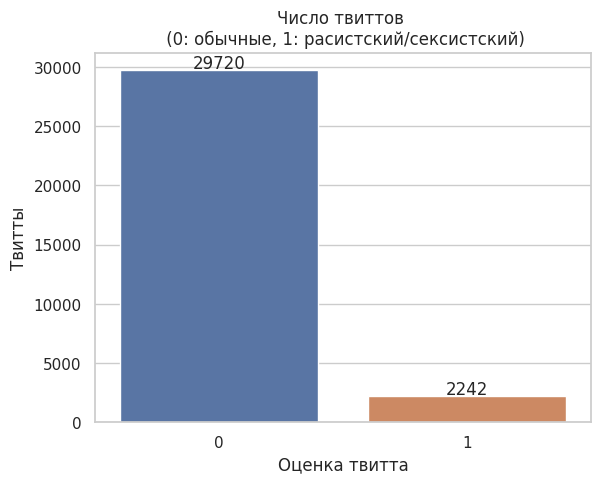

In [ ]:
sns.set_theme(style="whitegrid")

ax = sns.countplot(x=twtr_train_df['label'], data=twtr_train_df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Число твиттов \n (0: обычные, 1: расистский/сексистский)')
plt.xlabel('Оценка твитта')
plt.ylabel('Твитты')

Выведем позитивные твиттеры

In [ ]:
pos = twtr_train_df[twtr_train_df['label']==0]
pos.head(10)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...
7,0,the next school year is the year for exams.ð...
8,0,we won!!! love the land!!! #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...


Выведем негативные твиттеры

In [ ]:
neg = twtr_train_df[twtr_train_df['label']==1]
neg.head(10)

,label,tweet
13,1,@user #cnn calls #michigan middle school 'buil...
14,1,no comment! in #australia #opkillingbay #se...
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'...
56,1,@user lets fight against #love #peace
68,1,ð©the white establishment can't have blk fol...
77,1,"@user hey, white people: you can call people '..."
82,1,how the #altright uses &amp; insecurity to lu...
111,1,@user i'm not interested in a #linguistics tha...


Выведем слова встречающиеся в твиттерах в виде лого Твиттер. В дальнейшем сравним эти слова с обученной моделью

In [ ]:
#загрузим лого Твиттера
!gdown 1R_R45k7NINqDU7rsyoDODCSSLvNo55zQ

Downloading...
From: https://drive.google.com/uc?id=1R_R45k7NINqDU7rsyoDODCSSLvNo55zQ
To: /content/shutterstock_571681849.jpg
100% 82.1k/82.1k [00:00<00:00, 14.0MB/s]


Выведем список случайных позитивных слов необученной модели, используя фильтр 'label'==0

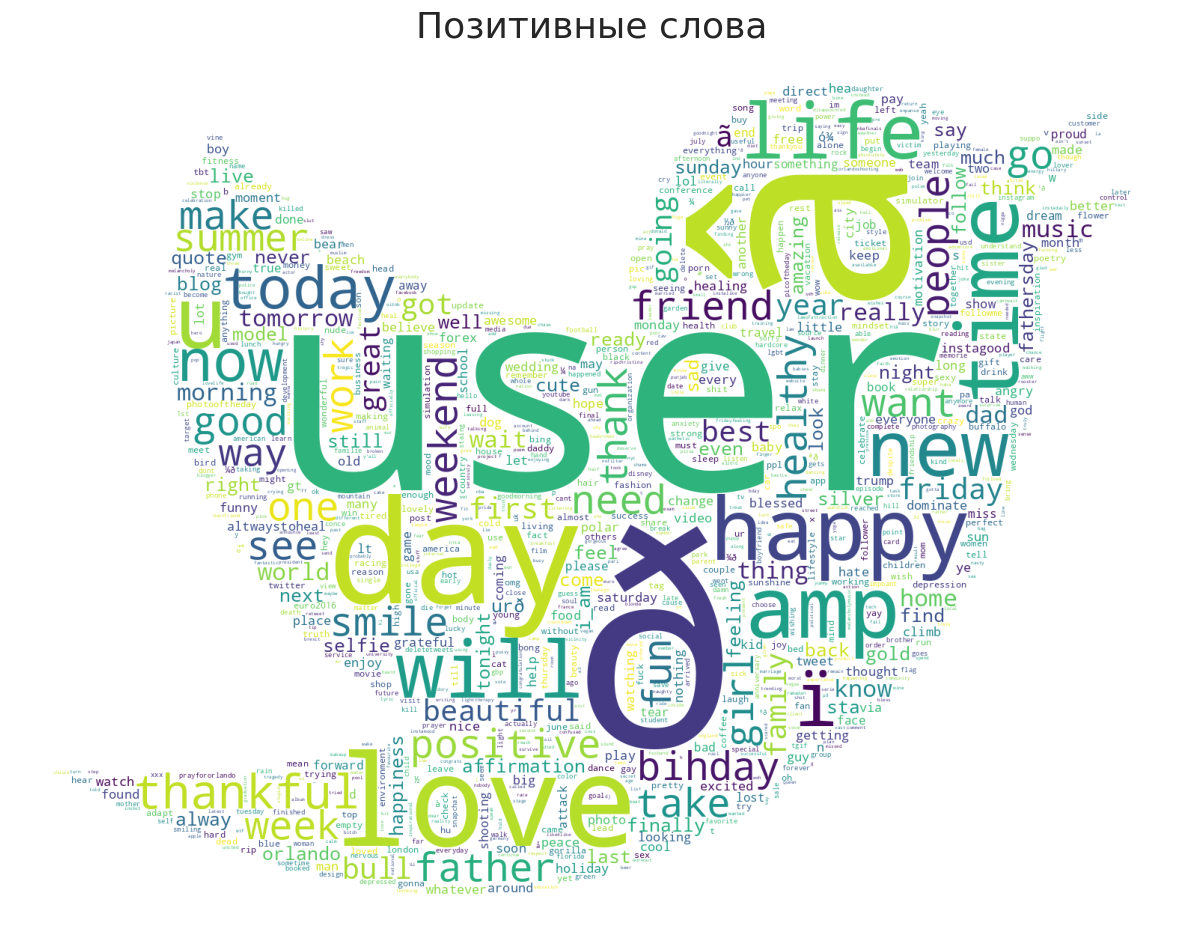

In [ ]:
twtr_mask = np.array(Image.open('/content/shutterstock_571681849.jpg'))

pos = " ".join(i for i in  twtr_train_df[twtr_train_df['label']==0].tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = twtr_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(pos)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.title('Позитивные слова', size=26)
plt.axis("off")
plt.show;

Выведем список случайных негативных слов необученной модели, используя фильтр 'label'==1

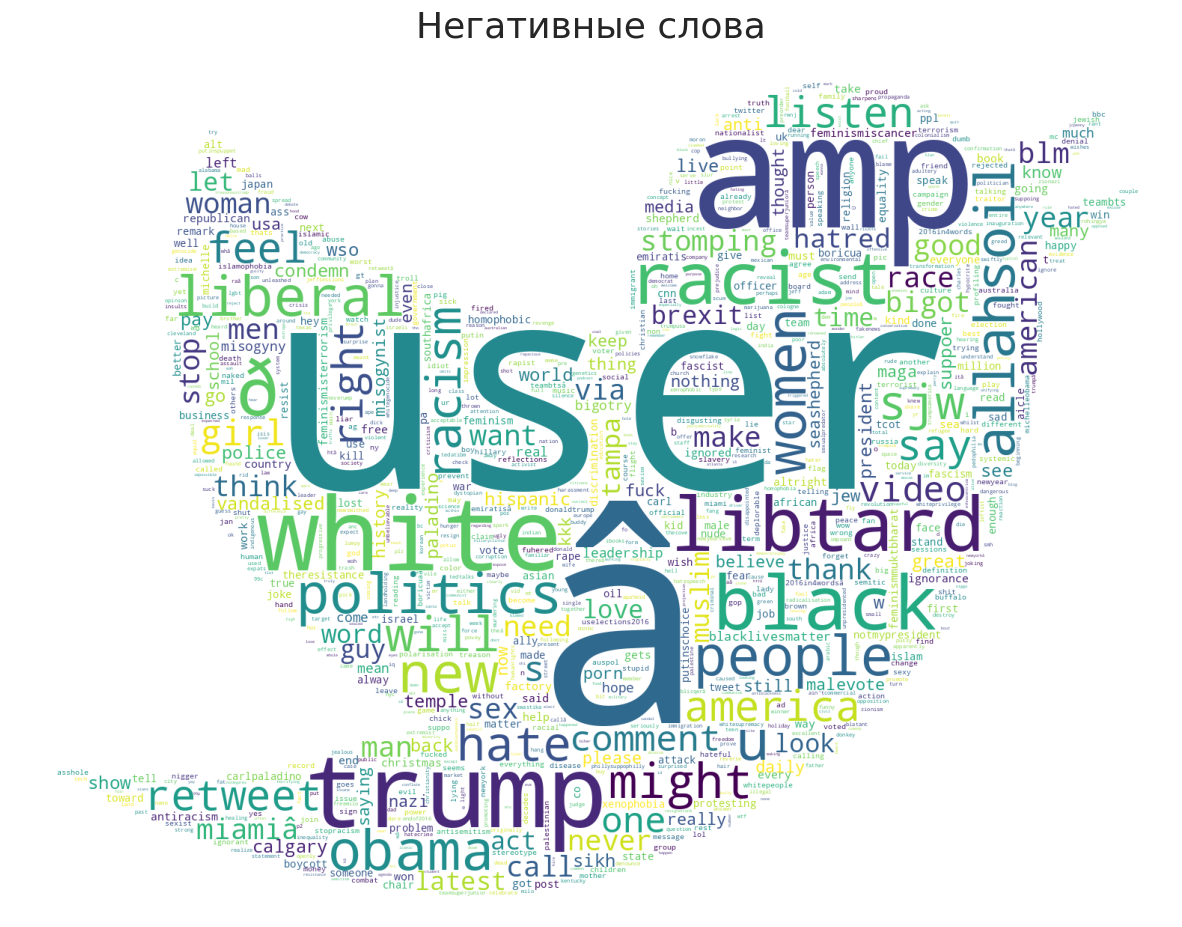

In [ ]:
twtr_mask = np.array(Image.open('/content/shutterstock_571681849.jpg'))

neg = " ".join(i for i in  twtr_train_df[twtr_train_df['label']==1].tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = twtr_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(neg)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.title('Негативные слова', size=26)
plt.axis("off")
plt.show;

# Подготовка данных

In [ ]:
#уменьшим регистр символов
twtr_train_df['tweet'] = twtr_train_df['tweet'].apply (lambda x:
                                                       " ".join (x.lower () for x in x.split ()))
twtr_train_df

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


In [ ]:
#удалим пунктуацию твиттов
twtr_train_df['tweet'] = twtr_train_df['tweet'].str.replace (r"""[^\w\s]+""",
                                                             "", regex = True)
twtr_train_df

,label,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for lyft credit i cant use ca...
2,0,bihday your majesty
3,0,model i love u take with u all the time in urð...
4,0,factsguide society now motivation
...,...,...
31957,0,ate user isz that youuuðððððððððâï
31958,0,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...
31960,1,user sikh temple vandalised in in calgary wso ...


In [ ]:
#лемматизация
nltk.download('wordnet')
twtr_train_df['tweet'] = twtr_train_df['tweet'].apply (lambda x:
                                                       " ".join ([Word(word).lemmatize () for word in x.split ()]))
twtr_train_df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,label,tweet
0,0,user when a father is dysfunctional and is so ...
1,0,user user thanks for lyft credit i cant use ca...
2,0,bihday your majesty
3,0,model i love u take with u all the time in urð...
4,0,factsguide society now motivation
...,...,...
31957,0,ate user isz that youuuðððððððððâï
31958,0,to see nina turner on the airwave trying to wr...
31959,0,listening to sad song on a monday morning otw ...
31960,1,user sikh temple vandalised in in calgary wso ...


Уберем часто встречающиеся слова

In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopWords = stopwords.words('english')

In [ ]:
#добавим к списку слов, также часто встречающееся в обоих классах слово "user"
stopWords.append('user')
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
#удалим часто встречающиеся слова
twtr_train_df['tweet'] = twtr_train_df['tweet'].apply (lambda x:
                                                       " ".join (x for x in x.split () if x not in stopWords))
twtr_train_df

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time urð ðððð ððð
4,0,factsguide society motivation
...,...,...
31957,0,ate isz youuuðððððððððâï
31958,0,see nina turner airwave trying wrap mantle gen...
31959,0,listening sad song monday morning otw work sad
31960,1,sikh temple vandalised calgary wso condemns act


**Проведем аналогичные операции для тестового датасета**

In [ ]:
#уменьшим регистр символов
twtr_test_df['tweet'] = twtr_test_df['tweet'].apply (lambda x:
                                                     " ".join (x.lower () for x in x.split ()))

In [ ]:
#удалим пунктуацию твиттов
twtr_test_df['tweet'] = twtr_test_df['tweet'].str.replace (r"""[^\w\s]+""",
                                                           "", regex = True)

In [ ]:
#лемматизация
twtr_test_df['tweet'] = twtr_test_df['tweet'].apply (lambda x:
                                                     " ".join ([Word(word).lemmatize () for word in x.split ()]))

In [ ]:
#удалим часто встречающиеся слова
twtr_test_df['tweet'] = twtr_test_df['tweet'].apply (lambda x:
                                                     " ".join (x for x in x.split () if x not in stopWords))
twtr_test_df

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacist want everyone see new â bird...
2,31965,safe way heal acne altwaystoheal healthy healing
3,31966,hp cursed child book reservation already yes ð...
4,31967,3rd bihday amazing hilarious nephew eli ahmir ...
...,...,...
17192,49155,thought factory leftright polarisation trump u...
17193,49156,feeling like mermaid ð hairflip neverready for...
17194,49157,hillary campaigned today ohioomg amp used word...
17195,49158,happy work conference right mindset lead cultu...


# **Алгоритм Multinomial Naive Bayes**

## Векторное представление текста

In [ ]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(twtr_train_df['tweet'])

CountVectorizer(binary=True)

In [ ]:
len(vectorizer.vocabulary_)

42639

## Train-test split

In [ ]:
df_train, df_test = train_test_split(twtr_train_df, test_size=0.2, shuffle=True)

In [ ]:
df_train.shape, df_test.shape

((25569, 2), (6393, 2))

In [ ]:
X_train = vectorizer.transform(df_train['tweet'])
X_test = vectorizer.transform(df_test['tweet'])

In [ ]:
X_train.shape, X_test.shape

((25569, 42639), (6393, 42639))

## Multinomial Naive Bayes

Реализуем алгоритм Multinomial Naive Bayes до реализации TF-IDF

In [ ]:
clf = MultinomialNB().fit(X_train, df_train['label'])

In [ ]:
# выбрать n лучших (по вероятностям) слов для каждого класса
def show_top(classifier, vectorizer, n, categories=('pos', 'neg')):
    # получаем слова
    feature_names = np.asarray(vectorizer.get_feature_names_out())
    # проходимлся по словам
    for i, category in enumerate(categories):
        # выбираем лучшие по вероятностям
        top = np.argsort(classifier.feature_log_prob_[i])[-n:]
        print("%s: %s" % (category, " ".join(feature_names[top])))

# отобразим 20 топовых слов
show_top(clf, vectorizer, 20)

pos: father wa people ððð one cant make good get new positive like im today life time amp happy day love
neg: say hate racism obama sjw wa might ha libtard allahsoil politics liberal people racist woman like black white trump amp


## Оценка

In [ ]:
predicts = clf.predict(X_test)
print(classification_report(df_test['label'], predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.97      0.97      0.97      5959
         neg       0.58      0.52      0.55       434

    accuracy                           0.94      6393
   macro avg       0.77      0.75      0.76      6393
weighted avg       0.94      0.94      0.94      6393



## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer().fit(df_train['tweet'])

In [ ]:
X_train_vectors = vectorizer.transform(df_train['tweet'])
X_test_vectors = vectorizer.transform(df_test['tweet'])

In [ ]:
num = 65
X_train_vectors[num].data

array([0.32344394, 0.29197597, 0.52443774, 0.42014024, 0.17680389,
       0.4305547 , 0.37675499])

Выведем слова из первого документа в порядке увеличения из меры TF-IDF:

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['love', 'would', 'wow', 'fantastic', 'prize', 'hubby', 'unchaed4'],
      dtype='<U91')

## Multinomial Naive Bayes + TF-IDF

In [ ]:
# обучим
clf = MultinomialNB().fit(X_train_vectors, df_train['label'])

In [ ]:
show_top(clf, vectorizer, 20)

pos: affirmation new good get like take bihday make amp today ððð im life father time positive happy thankful love day
neg: stomping listen hate racism retweet obama people might allahsoil sjw like politics liberal racist woman white black amp trump libtard


In [ ]:
predicts = clf.predict(vectorizer.transform(df_test['tweet']))
print(classification_report(df_test['label'], predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.94      1.00      0.97      5959
         neg       0.99      0.15      0.26       434

    accuracy                           0.94      6393
   macro avg       0.96      0.58      0.62      6393
weighted avg       0.94      0.94      0.92      6393



## TF-IDF + пары слов

Попробуем подсчитывать не только одиночные слова, но и пары слов:

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df_train['tweet'])

X_train_vectors = vectorizer.transform(df_train['tweet'])
X_test_vectors = vectorizer.transform(df_test['tweet'])

Выведем слова из первого документа в порядке увеличения из меры TF-IDF:

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['love', 'would', 'wow', 'fantastic', 'prize', 'hubby',
       'would love', 'fantastic prize', 'unchaed4 fantastic prize',
       'unchaed4 fantastic', 'unchaed4', 'prize would love',
       'love hubby wow', 'love hubby', 'would love hubby', 'hubby wow',
       'fantastic prize would', 'prize would'], dtype='<U101')

## Multinomial Naive Bayes + TF-IDF + пары слов

In [ ]:
clf = MultinomialNB(alpha = 1).fit(X_train_vectors, df_train['label'])

In [ ]:
show_top(clf, vectorizer, 20)

pos: like new good father day take bihday make amp today affirmation im life ððð father time happy positive thankful love day
neg: might woman racist liberal politics libtard sjw liberal libtard sjw libtard libtard sjw sjw liberal libtard libtard might libtard might libtard libtard sjw liberal politics sjw politics liberal white black amp trump libtard


In [ ]:
predicts = clf.predict(vectorizer.transform(df_test['tweet']))
print(classification_report(df_test['label'], predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.94      1.00      0.97      5959
         neg       1.00      0.12      0.21       434

    accuracy                           0.94      6393
   macro avg       0.97      0.56      0.59      6393
weighted avg       0.94      0.94      0.92      6393



Точность предсказания не отличается от TF-IDF



# **Алгоритм Complement Naive Bayes**

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer().fit(df_train['tweet'])
X_train_vectors = vectorizer.transform(df_train['tweet'])
X_test_vectors = vectorizer.transform(df_test['tweet'])

In [ ]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['love', 'would', 'wow', 'fantastic', 'prize', 'hubby', 'unchaed4'],
      dtype='<U91')

In [ ]:
clf = ComplementNB()
clf.fit(X_train_vectors, df_train['label'])

ComplementNB()

In [ ]:
predicts = clf.predict(vectorizer.transform(df_test['tweet']))
print(classification_report(df_test['label'], predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.96      0.98      0.97      5959
         neg       0.69      0.51      0.58       434

    accuracy                           0.95      6393
   macro avg       0.83      0.75      0.78      6393
weighted avg       0.95      0.95      0.95      6393



## TF-IDF + пары слов

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit(df_train['tweet'])
X_train_vectors = vectorizer.transform(df_train['tweet'])
X_test_vectors = vectorizer.transform(df_test['tweet'])

In [ ]:
print(X_train_vectors.shape)
print(X_test_vectors.shape)

(25569, 300696)
(6393, 300696)


In [ ]:
clf = ComplementNB()
clf.fit(X_train_vectors, df_train['label'])

ComplementNB()

In [ ]:
predicts = clf.predict(vectorizer.transform(df_test['tweet']))
print(classification_report(df_test['label'], predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.96      1.00      0.98      5959
         neg       0.90      0.41      0.56       434

    accuracy                           0.96      6393
   macro avg       0.93      0.70      0.77      6393
weighted avg       0.95      0.96      0.95      6393



Алгоритм Complement Naive Bayes при использовании TF-IDF дает лучший результат

# **Алгоритм Bernoulli Naive Bayes**

In [ ]:
clf = BernoulliNB().fit(X_train_vectors, df_train['tweet'])

Данный алгоритм вылетает по объему ОЗУ в Google Colab, не удалось им посчитать

# **Проверка на тестовом датасете**

Проверим работу модели на тестовой выборке

In [ ]:
#Будем использовать модель Complement Naive Bayes с TF-IDF
vectorizer = TfidfVectorizer().fit(df_train['tweet'])
X_train_vectors = vectorizer.transform(df_train['tweet'])
X_test_vectors = vectorizer.transform(df_test['tweet'])
clf = ComplementNB()
clf.fit(X_train_vectors, df_train['label'])

ComplementNB()

In [ ]:
#преобразование новых данных
test_vectors = vectorizer.transform(twtr_test_df['tweet'] )

#предсказание меток классов
predictions = clf.predict(test_vectors)
submission = pd.DataFrame({'tweet':twtr_test_df.tweet, 'label':predictions})
submission.head()

,tweet,label
0,studiolife aislife requires passion dedication...,0
1,white supremacist want everyone see new â bird...,0
2,safe way heal acne altwaystoheal healthy healing,0
3,hp cursed child book reservation already yes ð...,0
4,3rd bihday amazing hilarious nephew eli ahmir ...,0


Выведем число твиттов каждого класса для тестового датасета

Text(0, 0.5, 'Твитты')

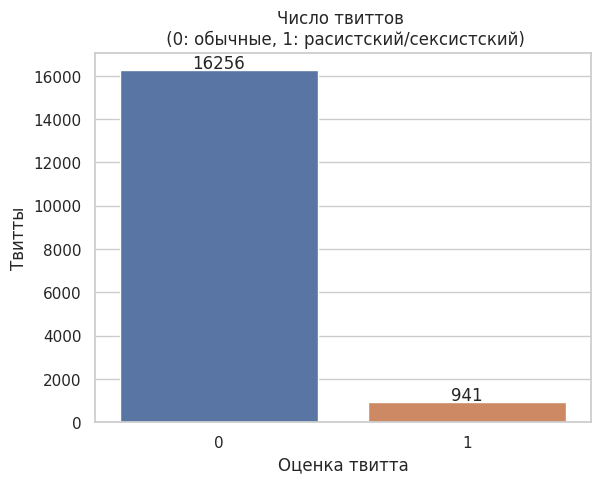

In [ ]:
ax = sns.countplot(x=submission['label'], data=submission)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Число твиттов \n (0: обычные, 1: расистский/сексистский)')
plt.xlabel('Оценка твитта')
plt.ylabel('Твитты')

Выведем негативные твитты

In [ ]:
submission[submission['label'] == 1]

,tweet,label
19,thought factory bbc neutrality right wing fasc...,1
26,chick get fucked hottest naked lady,1
33,suppo taiji fisherman bullying racism tweet4ta...,1
42,trump invested billion saudi empowers people f...,1
81,lt feeding public trough piggy michelleobamaâ,1
...,...,...
17125,careful criticizing obama decision israel amp ...,1
17128,uk governmentâs new antisemitism definition co...,1
17134,clearwaterstpeteairpo livelovelaugh floridalif...,1
17188,black professor demonizes proposes nazi style ...,1


Выведем негативные и позитивные слова тестового датасета

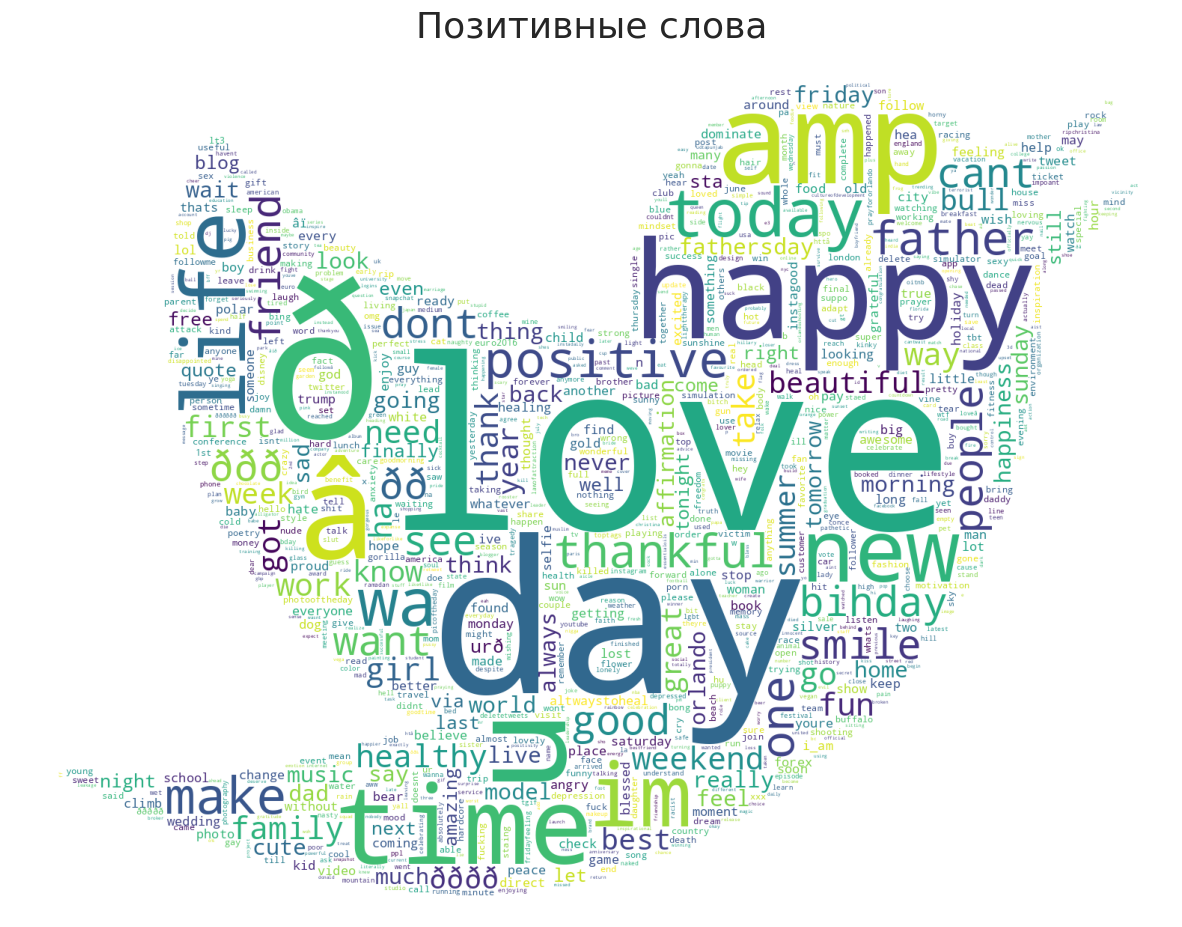

In [ ]:
twtr_mask = np.array(Image.open('/content/shutterstock_571681849.jpg'))

pos = " ".join(i for i in  submission[submission['label']==0].tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = twtr_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(pos)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.title('Позитивные слова', size=26)
plt.axis("off")
plt.show;

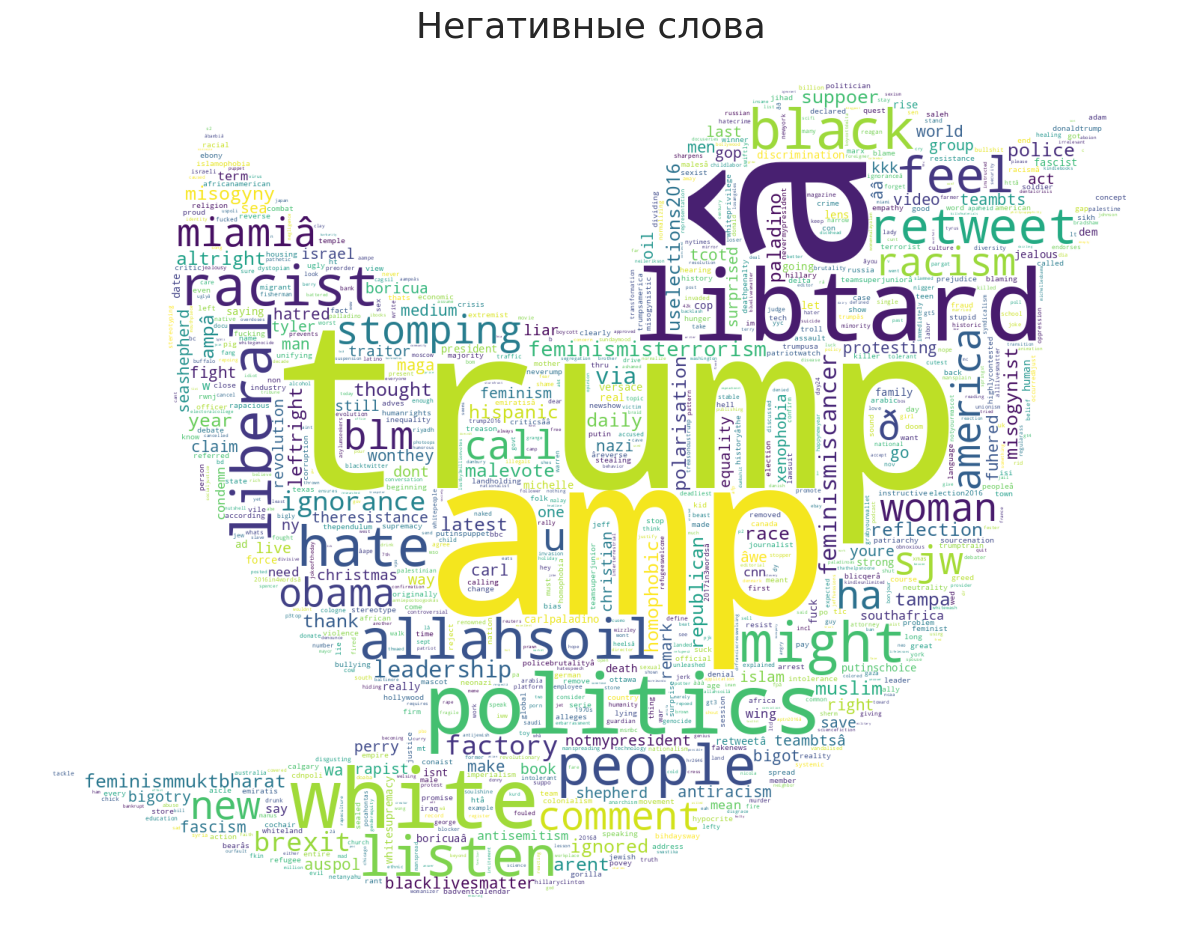

In [ ]:
twtr_mask = np.array(Image.open('/content/shutterstock_571681849.jpg'))

neg = " ".join(i for i in  submission[submission['label']==1].tweet)

wc = WordCloud(background_color = "white",
               width = 600, mask = twtr_mask,
               height = 600,
               contour_width = 0,
               contour_color = "red",
               max_words = 1000,
               scale = 1,
               collocations = False,
               repeat = True,
               min_font_size = 1)

wc.generate(neg)

plt.figure(figsize = [15, 15])
plt.imshow(wc)
plt.title('Негативные слова', size=26)
plt.axis("off")
plt.show;

Как видим по набору слов, алгоритм корректно определяет принадлежность тестового твитта к негативному и позитивному классу

#  **Обучение на основе эмбеддинга взвешенных по attention**

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Модель обучается крайне долго и вылетает по количеству оперативки, поэтому для проверки алгоритма ограничил размер датафрейма в 5000 строк. И то модель считалась 25 минут

In [ ]:
df = twtr_train_df[:5000]

In [ ]:
df

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thanks lyft credit cant use cause dont offer w...
2,0,bihday majesty
3,0,model love u take u time urð ðððð ððð
4,0,factsguide society motivation
...,...,...
4995,0,wasnt attack lgbt community america well may i...
4996,0,looking forward catching designer lucky enough...
4997,0,3 apps help keep amp healthy ðð½ðð blogginggals
4998,0,bestseller top10 sale never go bed without dre...


In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
#Sentences we want sentence embeddings for
sentences = df['tweet'].tolist()
labels = df['label'].tolist()

In [ ]:
#Train-test split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [ ]:
#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

In [ ]:
#Tokenize sentences
encoded_train = tokenizer(train_sentences,
                          padding=True,
                          truncation=True,
                          max_length=24,
                          return_tensors='pt')
encoded_test = tokenizer(test_sentences,
                         padding=True,
                         truncation=True,
                         max_length=24,
                         return_tensors='pt')

In [ ]:
#Compute token embeddings
with torch.no_grad():
    train_output = model(**encoded_train)
    test_output = model(**encoded_test)

train_embeddings = mean_pooling(train_output,
                                encoded_train['attention_mask'])
test_embeddings = mean_pooling(test_output,
                               encoded_test['attention_mask'])

In [ ]:
#Преобразуем данные в неотрицательные значения
scaler = MinMaxScaler()
train_embeddings = scaler.fit_transform(train_embeddings)
test_embeddings = scaler.transform(test_embeddings)

In [ ]:
#Обученим и оценим Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(train_embeddings, train_labels)
predicts = clf.predict(test_embeddings)
print(classification_report(test_labels, predicts, target_names=['pos', 'neg']))

              precision    recall  f1-score   support

         pos       0.96      0.93      0.95       935
         neg       0.32      0.46      0.38        65

    accuracy                           0.90      1000
   macro avg       0.64      0.70      0.66      1000
weighted avg       0.92      0.90      0.91      1000

